In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Part 1: Gathering Data
===

Part 1.1: Billboard Top 100 Web Scraping
===

In [11]:
# imports for web scraping
import requests
from bs4 import BeautifulSoup
import lxml
import re
from datetime import datetime, timedelta

In [12]:
top100 = pd.DataFrame()

url = 'https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_'
for year in range(1960, 2021):
    r = requests.get(url + str(year))
    html = r.content
    root = BeautifulSoup(r.content, "html.parser") 
    r = root.find("table", "wikitable")
    pretty = r.prettify()
    df = pd.read_html(pretty)[0]
    df.columns = ['Rank', 'Song', 'Artist(s)']
    df = df.assign(Year = year)
    top100 = top100.append(df)

top100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6101 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rank       6101 non-null   object
 1   Song       6101 non-null   object
 2   Artist(s)  6101 non-null   object
 3   Year       6101 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.3+ KB


In [15]:
# reformat rank to be integers
top100.loc[top100['Rank'] == 'Tie', 'Rank'] = 100
top100 = top100.astype({'Rank': 'int64'})

# remove quotations from song titles
top100["Song"] = top100["Song"].str.strip('"').str.strip()
top100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6101 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rank       6101 non-null   int64 
 1   Song       6101 non-null   object
 2   Artist(s)  6101 non-null   object
 3   Year       6101 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.3+ KB


In [ ]:
top100.to_csv('../data/RawYearlyTop100.csv', index=False)

Part 1.2: Spotify Track ID Collection
===

In [3]:
# imports for spotify searching
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [4]:
top100 = pd.read_csv('../data/RawYearlyTop100.csv')
top100.head()

,Rank,Song,Artist(s),Year
0,1,Theme from A Summer Place,Percy Faith,1960
1,2,He'll Have to Go,Jim Reeves,1960
2,3,Cathy's Clown,The Everly Brothers,1960
3,4,Running Bear,Johnny Preston,1960
4,5,Teen Angel,Mark Dinning,1960


In [6]:
top100["Artist(s)"] = top100["Artist(s)"].str.split('featuring', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split('and', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split('&', expand=True)[0]
top100["Artist(s)"] = top100["Artist(s)"].str.split(',', expand=True)[0]

top100["Song"] = top100["Song"].str.split("/", expand=True)[0]
top100["Song"] = top100["Song"].str.replace("'", " ")

In [7]:
top100["Query"] = "track:" + top100["Song"] + " artist:" + top100["Artist(s)"]
top100.head()

,Rank,Song,Artist(s),Year,Query
0,1,Theme from A Summer Place,Percy Faith,1960,track:Theme from A Summer Place artist:Percy F...
1,2,He ll Have to Go,Jim Reeves,1960,track:He ll Have to Go artist:Jim Reeves
2,3,Cathy s Clown,The Everly Brothers,1960,track:Cathy s Clown artist:The Everly Brothers
3,4,Running Bear,Johnny Preston,1960,track:Running Bear artist:Johnny Preston
4,5,Teen Angel,Mark Dinning,1960,track:Teen Angel artist:Mark Dinning


In [8]:
with open('../config.json') as file:
    app_data = json.load(file)

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In [9]:
def add_data_to_row(row, track):
    row['ID'] = track['id']
    row['Popularity'] = track['popularity']
    row['Release Date'] = track['album']['release_date']
    artists = []
    for i, artist in enumerate(track['artists']):
        artists.append(artist['id'])
    row['Artist IDs'] = artists
    row['Album ID'] = track['album']['id']
    return row

In [ ]:
count_missing = 0
new_columns = ["Year", "Rank", "ID", "Song", "Artist(s)", "Artist IDs", "Album ID", "Release Date", "Popularity", "Query"]
results = pd.DataFrame(columns=new_columns)
no_results = pd.DataFrame(columns = ["Year", "Rank", "Song", "Artist(s)", "Query"])

for i, row in top100.iterrows():
    search_res = sp.search(q=row['Query'], limit=5)
    tracks = search_res['tracks']['items']
    if len(tracks) == 0:
        count_missing += 1
        new_query = row["Artist(s)"] + row["Song"]
        search2_res = sp.search(q=new_query, limit=5)
        tracks2 = search2_res['tracks']['items']
        if len(tracks2) == 0:
            no_results = no_results.append(row, ignore_index=True)
        else:
            for idx, track in enumerate(tracks):
                row = add_data_to_row(row, track)
                results = results.append(row, ignore_index=True)
    else:
        for idx, track in enumerate(tracks):
            row = add_data_to_row(row, track)
            results = results.append(row, ignore_index=True)

results.to_csv('../data/search-results/all.csv', index=False)
no_results.to_csv('../data/search-results/all_missing.csv', index=False)

Part 1.3: ID selection
===

The spotify search provides up to 5 results for the track. We must select the most appropriate track to use.

In [16]:
results = pd.read_csv('../data/search-results/all.csv')
results.loc[results['Release Date'] == "0000",'Release Date'] = None
results['Release Date'] = pd.to_datetime(results['Release Date'])

In [17]:
selected = pd.DataFrame()
for q, song in results.groupby(['Query','Year']):
    oldest = song.iloc[0]
    for i, result in song.iterrows():
        if (result['Release Date']) < (oldest['Release Date']):
            oldest = result
    selected = selected.append(oldest, ignore_index=True)
selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6070 entries, 0 to 6069
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Album ID      6070 non-null   object        
 1   Artist IDs    6070 non-null   object        
 2   Artist(s)     6070 non-null   object        
 3   ID            6070 non-null   object        
 4   Popularity    6070 non-null   float64       
 5   Query         6070 non-null   object        
 6   Rank          6070 non-null   float64       
 7   Release Date  6070 non-null   datetime64[ns]
 8   Song          6070 non-null   object        
 9   Year          6070 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 474.3+ KB


In [ ]:
selected.to_csv('../data/search-results/all_selected.csv', index=False)

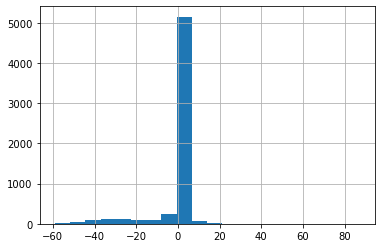

In [21]:
differences = ((selected['Year'] - selected['Release Date'].dt.year))
differences.hist(bins=20)
display()
# TODO: make a better visualization of why this selection works

Part 1.4: Get Audio Features
===

In [22]:
# uses the same imports as spotify ID search

with open('../config.json') as file:
    app_data = json.load(file)

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In [23]:
all_years = pd.read_csv('../data/search-results/all_selected.csv')
delete_row = all_years[(all_years["Year"]==2005.0) & (all_years["Rank"] == 80)].index
all_years = all_years.drop(delete_row)

In [24]:
all_audio_features = pd.DataFrame()
for rank_val, rank in all_years.groupby('Rank'):
    audio_features = pd.DataFrame (sp.audio_features(tracks=rank['ID']))
    rank_and_features = rank.merge(audio_features, left_on='ID', right_on='id', how='inner')
    rank_and_features = rank_and_features.drop(columns=['track_href','type','uri','analysis_url','id'])
    all_audio_features = all_audio_features.append(rank_and_features)

all_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6069 entries, 0 to 61
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Album ID          6069 non-null   object 
 1   Artist IDs        6069 non-null   object 
 2   Artist(s)         6069 non-null   object 
 3   ID                6069 non-null   object 
 4   Popularity        6069 non-null   float64
 5   Query             6069 non-null   object 
 6   Rank              6069 non-null   float64
 7   Release Date      6069 non-null   object 
 8   Song              6069 non-null   object 
 9   Year              6069 non-null   float64
 10  danceability      6069 non-null   float64
 11  energy            6069 non-null   float64
 12  key               6069 non-null   int64  
 13  loudness          6069 non-null   float64
 14  mode              6069 non-null   int64  
 15  speechiness       6069 non-null   float64
 16  acousticness      6069 non-null   float64
 1

In [ ]:
all_audio_features.to_csv('../data/Billboard_Audio_Features.csv', index=False)

Part 1.4: Get Genre
===

In [25]:
# uses the same imports as spotify ID search 

with open('../config.json') as file:
    app_data = json.load(file)

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials( \
                     client_id=app_data['client_id'], \
                     client_secret=app_data['client_secret']))

In [26]:
all_years = pd.read_csv('../data/Billboard_Audio_Features.csv')

In [27]:
all_years = pd.read_csv('../data/Billboard_Audio_Features.csv')
all_years['Artist IDs'] = all_years['Artist IDs'].str.lstrip('[').str.rstrip(']')
all_years['Primary Artist ID'] = all_years['Artist IDs'].str.split(',', expand = True)[0].str.strip("'")
all_years['Genres'] = pd.Series(dtype=object)
all_with_genres = pd.DataFrame(columns=all_years.columns)

In [ ]:
all_years = all_years.tail(3408)
for i, row in all_years.iterrows():
    artist = sp.artist(row['Primary Artist ID'])
    row['Genres'] = ", ".join(artist["genres"])
    all_with_genres = all_with_genres.append(row, ignore_index= True)

In [ ]:
all_with_genres.to_csv('../data/Billboard_Audio_Features.csv', index=False)

In [33]:
data = pd.read_csv('../data/Billboard_Audio_Features.csv')
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5746 entries, 0 to 5745
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Album ID           5746 non-null   object 
 1   Artist IDs         5746 non-null   object 
 2   Artist(s)          5746 non-null   object 
 3   ID                 5746 non-null   object 
 4   Popularity         5746 non-null   float64
 5   Query              5746 non-null   object 
 6   Rank               5746 non-null   float64
 7   Release Date       5746 non-null   object 
 8   Song               5746 non-null   object 
 9   Year               5746 non-null   float64
 10  danceability       5746 non-null   float64
 11  energy             5746 non-null   float64
 12  key                5746 non-null   int64  
 13  loudness           5746 non-null   float64
 14  mode               5746 non-null   int64  
 15  speechiness        5746 non-null   float64
 16  acousticness       5746 

In [34]:
# rewrite with np.where or apply
new_data = pd.DataFrame(columns=data.columns)

for i, row in data.iterrows():
    genre = np.nan
    genres = row["Genres"]
    if "country" in genres:
        genre = "country"
    elif "disco" in genres:
        genre = "disco"
    elif "edm" in genres or "electro" in genres:
        genre = "edm"
    elif "r&b" in genres or "soul" in genres:
        genre = "soul/r&b"
    elif "hip hop" in genres or "rap" in genres:
        genre = "hip hop/rap"
    elif "alternative" in genres or "indie" in genres:
        genre = "alternative/indie"
    elif "rock" in genres or "pop" in genres:
        rock = 0
        pop = 0
        for g in genres.split(','):
            if "rock" in g:
                rock += 1
            if "pop" in g:
                pop += 1
        if rock >= pop:
            genre = "rock"
        else:
            genre = "pop"
    row["Top Genre"] = genre
    new_data = new_data.append(row)

new_data['Top Genre'].value_counts()

rock                 1290
pop                  1063
soul/r&b              957
hip hop/rap           771
country               603
disco                 426
edm                   159
alternative/indie     155
Name: Top Genre, dtype: int64

In [ ]:
new_data.to_csv('../data/Billboard_Audio_Features.csv', index=False)

In [36]:
data['Genres'].value_counts()[:25]

dance pop, pop, post-teen pop                                                      104
dance pop, pop                                                                      61
contemporary country, country, country road                                         52
dance pop, pop, urban contemporary                                                  51
bubblegum pop                                                                       43
karaoke                                                                             40
barbadian pop, dance pop, pop, pop rap, post-teen pop, urban contemporary           32
soft rock                                                                           30
pop, post-teen pop                                                                  28
canadian hip hop, canadian pop, hip hop, pop rap, rap, toronto rap                  28
glam rock, mellow gold, piano rock, soft rock                                       27
beatlesque, british invasion, classic rock,

Part 2: Explanatory Data Analysis
===

Part 2.1: Exploration of Features
===

In [39]:
# imports
import seaborn as sn

In [40]:
data = pd.read_csv('../data/Billboard_Audio_Features.csv')
data = data.drop(columns=['Album ID', 'Artist IDs', 'Query', 'Song', 'Artist(s)'])
data = data.dropna()
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5424 entries, 0 to 5745
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5424 non-null   object 
 1   Popularity         5424 non-null   float64
 2   Rank               5424 non-null   float64
 3   Release Date       5424 non-null   object 
 4   Year               5424 non-null   float64
 5   danceability       5424 non-null   float64
 6   energy             5424 non-null   float64
 7   key                5424 non-null   int64  
 8   loudness           5424 non-null   float64
 9   mode               5424 non-null   int64  
 10  speechiness        5424 non-null   float64
 11  acousticness       5424 non-null   float64
 12  instrumentalness   5424 non-null   float64
 13  liveness           5424 non-null   float64
 14  valence            5424 non-null   float64
 15  tempo              5424 non-null   float64
 16  duration_ms        5424 

,ID,Popularity,Rank,Release Date,Year,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Primary Artist ID,Genres,Top Genre
0,5HQ6AUDMbMuwktvcNPuV1y,36.0,1.0,1991-01-01,1991.0,0.521,0.349,1,-13.452,1,...,0.06480,0.000013,0.0550,0.273,131.189,398027,4,3Z02hBLubJxuFJfhacLSDc,"album rock, canadian pop, canadian singer-song...",rock
1,0mUyMawtxj1CJ76kn9gIZK,75.0,1.0,2005-02-22,2006.0,0.599,0.785,3,-4.013,1,...,0.44800,0.003360,0.1510,0.520,140.046,233640,4,7xTcuBOIAAIGDOSvwYFPzk,"canadian pop, neo mellow, pop rock",pop
2,2goLsvvODILDzeeiT4dAoR,76.0,1.0,1998-01-01,1999.0,0.652,0.917,6,-6.720,1,...,0.00820,0.000000,0.0509,0.459,132.975,239027,4,72OaDtakiy6yFqkt4TsiFt,"dance pop, hollywood, new wave pop, pop, pop rock",pop
3,0kPeymTUiaidv48eRrMISu,64.0,1.0,2007-01-01,1981.0,0.659,0.541,5,-7.919,1,...,0.01740,0.000000,0.1980,0.560,116.685,224693,4,5PN2aHIvLEM98XIorsPMhE,"new wave pop, soft rock",rock
4,0VjIjW4GlUZAMYd2vXMi3b,94.0,1.0,2020-03-20,2020.0,0.514,0.730,1,-5.934,1,...,0.00146,0.000095,0.0897,0.334,171.005,200040,4,1Xyo4u8uXC1ZmMpatF05PJ,"canadian contemporary r&b, canadian pop, pop",soul/r&b


Feature Ranges:
- acousticness 0.0 - 1.0
- danceability 0.0 - 1.0
- energy 0.0 - 1.0
- instrumentalness 0.0 - 1.0
- liveness 0.0 - 1.0
- speechiness 0.0 - 1.0
-  valence 0.0 - 1.0
- popularity 0 - 100
- time_signature categorical
- tempo bpm
- loadness -60 - 0
- mode major vs minor
- key categorical
- duration_ms positive integer

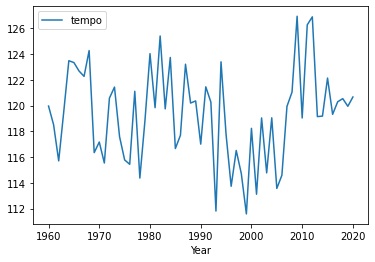

In [41]:
avgs = data.groupby("Year").mean().reset_index()
ax = avgs.plot(x="Year", y="tempo")

avgs['Popularity'] = avgs['Popularity'] / 100

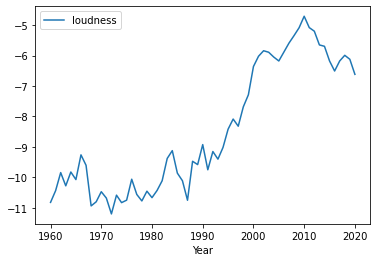

In [42]:
ax = avgs.plot(x="Year", y="loudness")

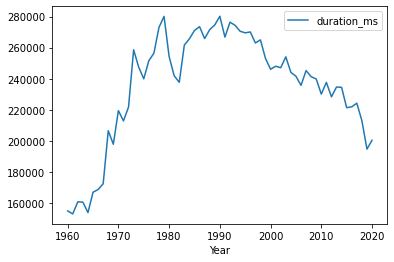

In [43]:
ax = avgs.plot(x="Year", y="duration_ms")

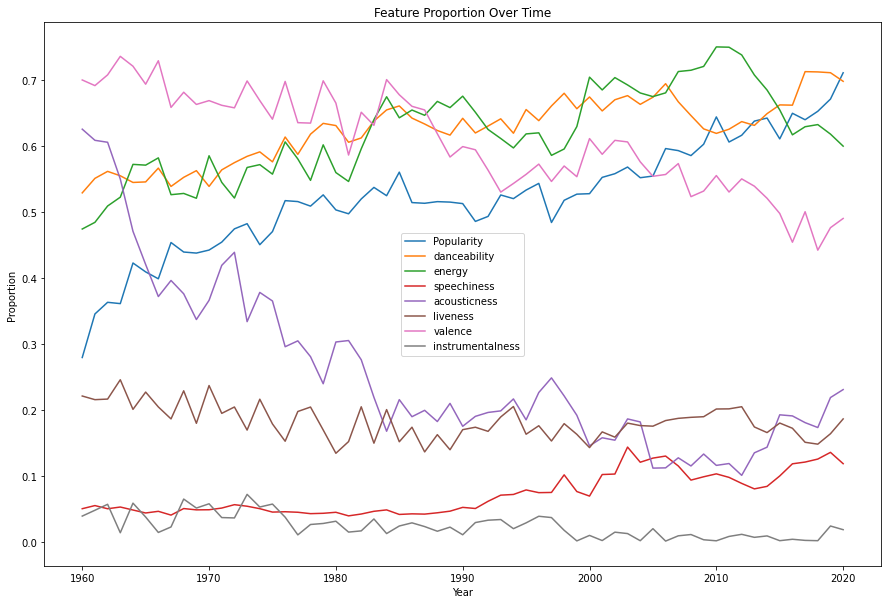

In [44]:
features = ['danceability','energy','speechiness','acousticness','liveness','valence', 'instrumentalness']

ax = avgs.plot(x="Year", y='Popularity', figsize=(15,10))

for feature in features:
    avgs.plot(x="Year", y=feature, ax=ax)

ax.set_ylabel('Proportion')
ax.set_title('Feature Proportion Over Time')

display()

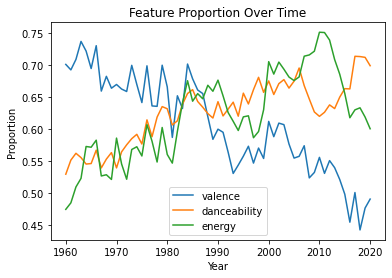

In [45]:
ax = avgs.plot(x="Year", y='valence')
features = ['danceability','energy']

for feature in features:
    avgs.plot(x="Year", y=feature, ax=ax)

ax.set_ylabel('Proportion')
ax.set_title('Feature Proportion Over Time')

display()

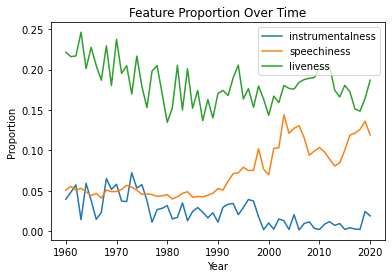

In [46]:
ax = avgs.plot(x="Year", y='instrumentalness')
features = ['speechiness','liveness']

for feature in features:
    avgs.plot(x="Year", y=feature, ax=ax)

ax.set_ylabel('Proportion')
ax.set_title('Feature Proportion Over Time')

display()

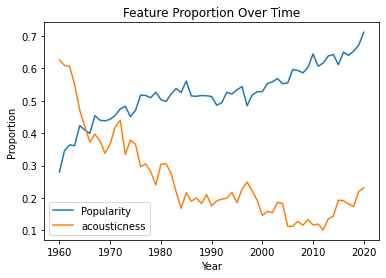

In [47]:
ax = avgs.plot(x="Year", y='Popularity')
features = ['acousticness']

for feature in features:
    avgs.plot(x="Year", y=feature, ax=ax)

ax.set_ylabel('Proportion')
ax.set_title('Feature Proportion Over Time')

display()

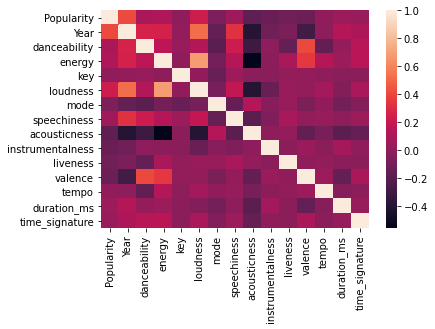

In [48]:
corrs = data.drop(['Rank'], axis=1).corr()
sn.heatmap(corrs)
plt.show()

Part 2.2: Exploration of Genre
===

In [49]:
data.groupby('Top Genre').mean()[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
Top Genre,,,,,,,,,,,,,
alternative/indie,0.542510,0.741785,4.806452,-6.095174,0.774194,0.043202,0.104419,0.022460,0.173363,0.528571,124.011626,243029.658065,3.954839
country,0.576854,0.596515,5.316750,-9.108643,0.854063,0.043375,0.300146,0.012771,0.176951,0.609237,121.208128,225771.673300,3.966833
disco,0.650005,0.586485,5.401408,-10.640622,0.629108,0.049814,0.293952,0.042251,0.186396,0.690267,118.331310,270524.835681,3.955399
edm,0.671069,0.698082,5.364780,-5.749308,0.591195,0.100986,0.142479,0.027229,0.160148,0.526826,119.645428,220808.044025,3.987421
hip hop/rap,0.734201,0.679448,5.654994,-6.289724,0.573281,0.171719,0.116275,0.013333,0.201890,0.558777,118.736595,239301.067445,3.998703
pop,0.624875,0.646237,5.233302,-7.744183,0.688617,0.057938,0.261869,0.024659,0.175172,0.602963,118.965252,227133.331138,3.971778
rock,0.560775,0.612283,5.083721,-9.424492,0.788372,0.045340,0.295345,0.028425,0.184704,0.607356,122.029451,231397.483721,3.944186
soul/r&b,0.664520,0.573771,5.560084,-8.615846,0.594566,0.079703,0.273966,0.022854,0.172080,0.618500,114.954679,244294.026123,3.936259


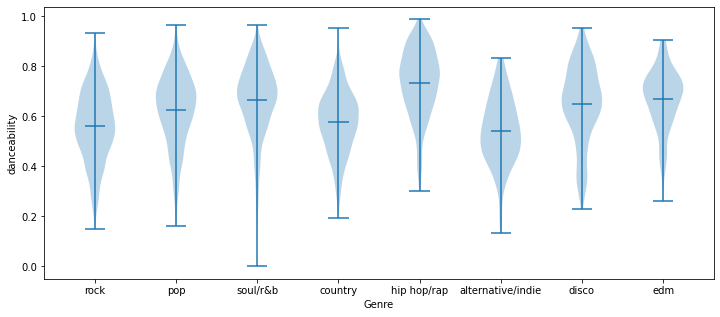

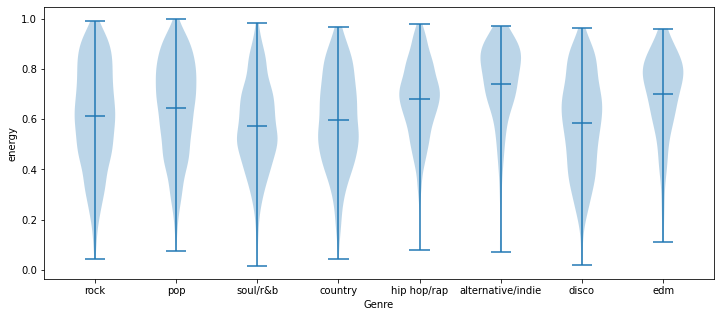

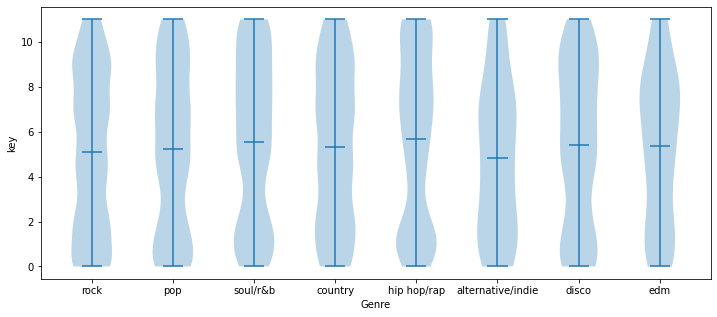

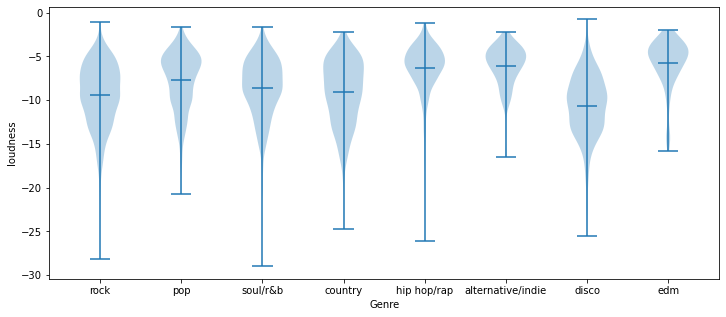

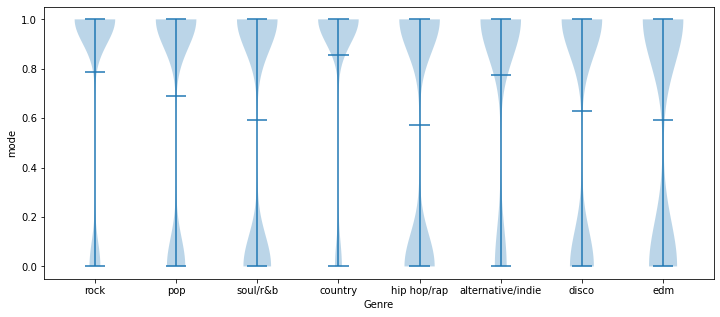

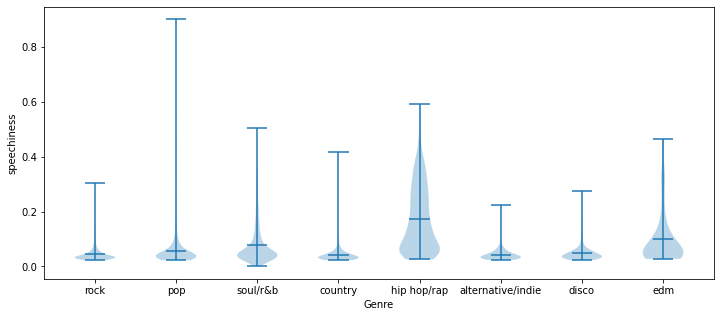

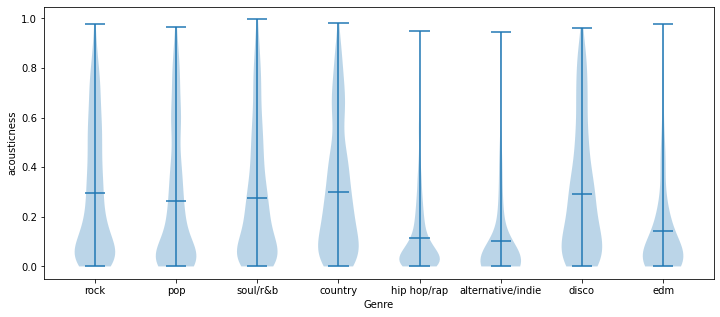

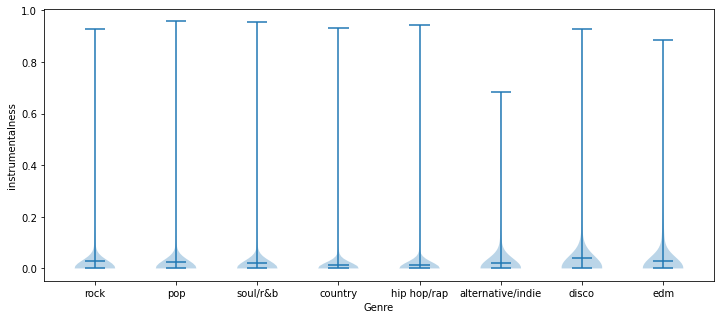

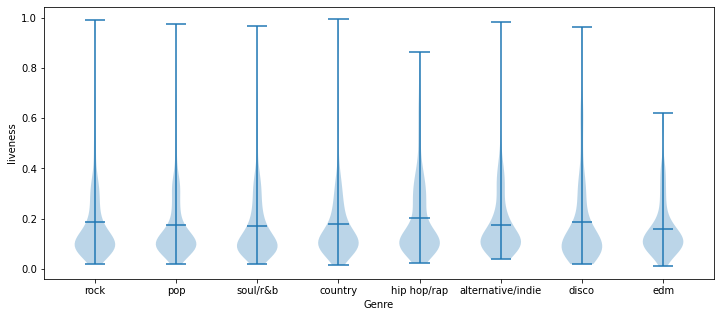

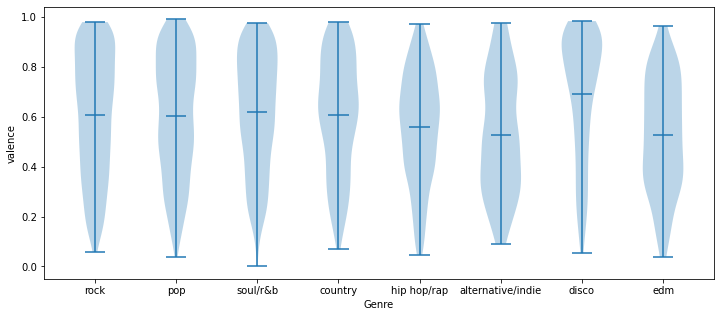

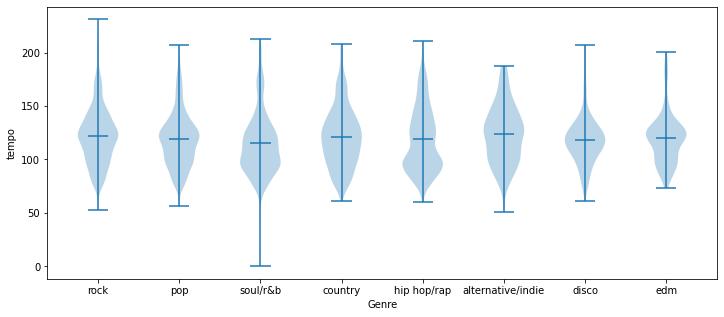

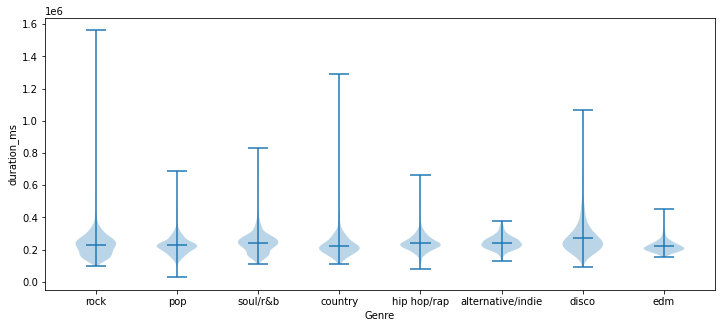

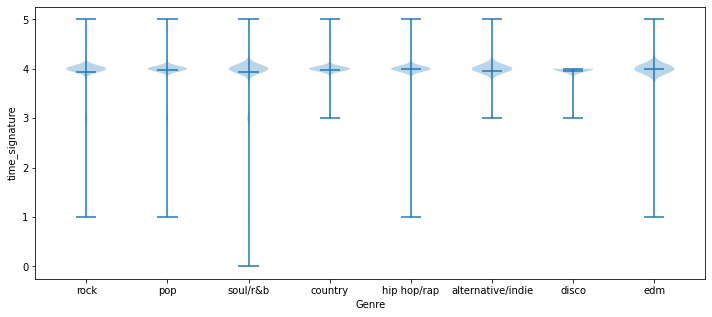

In [51]:
genres = data['Top Genre'].unique()
feature_by_genre = []
#fig, ax = plt.subplots(5, 1, sharex='col', sharey='col', figsize=(7.5,10))
#plt.subplots_adjust(hspace=0.3)


for feature in ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']:
    feture_by_genre = [data.loc[data["Top Genre"] == genre][feature].values for genre in genres]
    plt.figure(figsize=(12, 5))
    plt.violinplot(feture_by_genre, range(0, len(genres)), showmeans=True)
    plt.xticks(range(0, len(genres)), labels=genres)
    plt.xlabel("Genre")
    plt.ylabel(feature)

Part 3: Hypothesis Testing
===

In [ ]:
from sklearn import linear_model
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Part 4: Modeling / ML
===

Part 5: Conclusion
===